In [1]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from fredapi import Fred
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LassoLarsCV, LassoLars, lasso_path, Lasso, LassoCV, LinearRegression
# Algorithms
from statistics import mean, stdev, variance
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from collections import Counter
from sklearn.decomposition import PCA
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str

In [2]:
csv = pd.read_csv("monthly_data.csv")


In [3]:
fred = Fred(api_key='3c6ba58d26525f17af95af4fabed24be')


In [4]:
csv2 = csv[50:-20]
csv2 = csv2.drop(['SMU06419406562200001.1', 'SMU21000006056170001SA.1'], axis=1)

In [5]:
data = csv2.dropna(axis="columns")[8::3].reset_index(drop=True)
date = data['Unnamed: 0']
data = data.drop(["Unnamed: 0"], axis=1)
data

,UNRATE,CPIAUCSL,FEDFUNDS,CSUSHPINSA,M2SL,M1SL,PSAVERT,PAYEMS,INDPRO,TB3MS,...,ESTPIEAMP01GPM,BROSERPA158MFRBDAL,LARTTULA158MFRBDAL,LAUCN310910000000004,LAUCN271470000000004,LFWATTFECAM647N,LFWA55FECAM647S,LFWA55FEKRM647S,LFWA55MAAUM647N,LFWA55MAAUM647S
0,5.4,191.700,1.93,157.497,6399.4,1374.2,4.0,132503.0,97.6137,2.07,...,-0.202429,-1.713722,2.689583,12.0,712.0,12971900.0,1725500.0,2.143286e+06,1063251.0,1.062949e+06
1,5.4,192.400,2.50,161.924,6432.5,1371.1,3.2,133032.0,99.4639,2.54,...,-0.201410,1.561165,16.658304,25.0,983.0,13010400.0,1745200.0,2.138804e+06,1072885.0,1.073819e+06
2,5.1,193.600,3.00,169.544,6473.1,1366.0,3.5,133690.0,99.6033,2.84,...,-0.100604,1.090706,-4.866917,11.0,747.0,13057400.0,1763600.0,2.166473e+06,1081863.0,1.081815e+06
3,4.9,196.100,3.50,175.922,6569.8,1377.8,2.6,134498.0,99.9435,3.44,...,1.206030,9.230125,-3.218818,9.0,726.0,13110300.0,1782100.0,2.175409e+06,1090390.0,1.090723e+06
4,5.0,198.100,4.00,179.675,6654.5,1376.1,3.5,134993.0,100.3216,3.88,...,0.000000,2.638735,6.844361,8.0,713.0,13152700.0,1798800.0,2.175877e+06,1099186.0,1.098971e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,3.7,256.118,2.13,211.802,14938.8,3844.0,7.3,151108.0,109.8543,1.95,...,-0.223881,2.935424,-1.687233,13.0,642.0,15569800.0,2620100.0,3.998115e+06,1437108.0,1.438242e+06
60,3.6,257.989,1.55,212.222,15254.4,3955.6,7.5,151758.0,110.0388,1.54,...,0.150376,5.135172,-4.344529,11.0,505.0,15624700.0,2625300.0,4.015310e+06,1444387.0,1.443890e+06
61,3.5,258.824,1.58,213.295,15473.4,4027.6,8.3,152523.0,109.2966,1.52,...,-0.452489,4.145019,2.584733,13.0,752.0,15663700.0,2629400.0,4.020187e+06,1450121.0,1.449740e+06
62,13.3,255.942,0.05,218.569,17893.0,16275.9,24.7,132994.0,92.0613,0.13,...,-0.152555,58.708814,23.355997,10.0,1953.0,15693800.0,2633500.0,4.032882e+06,1453775.0,1.453747e+06


In [6]:
target = pd.read_csv("micron.csv").drop("date", axis=1)[::-1].reset_index().drop("index", axis=1)
target

,sales
0,1308
1,1054
2,1258
3,1362
4,1225
...,...
60,4797
61,5438
62,6056
63,5773


In [7]:
full = data.join(target)

In [8]:
names = full
scaler = MinMaxScaler()
full = MinMaxScaler().fit_transform(full)
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(full))))
full = np.transpose(full)

In [9]:
since = time.time()
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(full))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(full[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(full)
som.train(full, 50000)
time_elapsed = time.time() - since
print(f"SOM clustering executed in {time_elapsed // 60}m {time_elapsed % 60}s ")

SOM clustering executed in 0.0m 5.60675835609436s 


In [10]:
since = time.time()
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(full)

time_elapsed = time.time() - since
print(f"PCA clustering executed in {time_elapsed // 60}m {time_elapsed % 60}s ")

PCA clustering executed in 0.0m 0.36398911476135254s 


In [11]:
since = time.time()
cluster_count = math.ceil(math.sqrt(len(full))) 
print(cluster_count)
kmeans = KMeans(n_clusters=60,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)
time_elapsed = time.time() - since
print(f"Kmeans on PCA clustering executed in {time_elapsed // 60}m {time_elapsed % 60}s ")

297
Kmeans on PCA clustering executed in 0.0m 38.45721125602722s 


In [12]:
cluster_map = []
i = 0
cluster_x = []
cluster_dict = {}
for idx in names:
    winner_node = som.winner(full[i])
    name = f"Cluster {winner_node[0] * som_y + winner_node[1] + 1}"
    cluster_map.append((idx, name))

    cluster_x.append(name)
    i += 1

cluster_x = Counter(cluster_x)
clusters = pd.DataFrame(cluster_map, columns=["Name", "Cluster"]).sort_values(by="Cluster").set_index("Name")

In [13]:
cluster = clusters.loc["sales"].values
value = clusters["Cluster"].values
index = list(np.where(value ==cluster)[0])
names = list(clusters.index.values[index])
names.remove("sales")
names

['WPS011101',
 'WPU011101',
 'MADI555SRVON',
 'SMU15000006562200001SA',
 'SMU17294044300000001SA',
 'PCU5242105242104',
 'SMU55333403000000030SA',
 'SMU55333403000000030',
 'SMU17294044300000001',
 'SMU54000006562000007SA',
 'SMU25731046055000001SA',
 'CP0510MTM086NEST',
 'SMU54000006562000007',
 'SMU25716543000000030',
 'SMU29000005000000008',
 'MADI555SRVO',
 'SMU15000006562200001',
 'SMU25731046055000001',
 'SMU25716543000000030SA']

In [14]:
corrs = {}
for name in data:
    x = data[name]
    
    corrs[abs(x.corr(target["sales"]))] = name

KeyboardInterrupt: 

In [15]:
names = []
for num in sorted(corrs)[:-40:-1]:
    names.append(corrs[num])
for num in sorted(corrs)[:10:1]:
    names.append(corrs[num])

In [30]:
data = data[names].iloc(axis=1)[np.where(clf.coef_ != 0)[0]]

In [31]:
full = data.join(target)

In [32]:
full

,WPS011101,WPU011101,PCU5242105242104,SMU55333403000000030SA,CP0510MTM086NEST,SMU25716543000000030,SMU25716543000000030SA,sales
0,155.5,149.3,100.2,705.442981,93.64,781.15,776.930845,1308
1,153.1,121.9,100.2,687.649054,94.11,796.22,789.360768,1054
2,157.2,150.1,100.2,683.784385,94.10,790.66,796.977835,1258
3,125.8,154.7,100.2,679.273921,94.45,762.40,768.004777,1362
4,151.8,143.2,100.2,737.000379,94.58,738.40,734.249098,1225
...,...,...,...,...,...,...,...,...
59,218.9,227.2,103.0,931.342190,117.12,1079.89,1075.492022,5144
60,262.5,264.8,103.0,896.692752,116.80,1065.08,1062.832261,4797
61,272.2,260.0,103.0,927.025729,115.80,1011.78,1011.961542,5438
62,291.5,290.1,103.0,848.513674,115.99,1082.68,1072.706376,6056


In [33]:
X, y = full.iloc[:,:-1],full.iloc[:,-1]


In [34]:
data_dmatrix = xgb.DMatrix(data=X,label=y)



In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [36]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3,learning_rate = 0.2,
                max_depth = 10, alpha = 5,n_estimators = 300, tree_method="gpu_hist")

In [37]:
xg_reg.fit(X_train,y_train)


[09:59:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=5, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [38]:
preds = xg_reg.predict(X_test)


In [39]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 617.414054


In [40]:
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

LinearRegression(normalize=True)

In [41]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 544.266053


In [27]:
clf = LassoCV(cv = 5, normalize=True, max_iter=200000).fit(X_train, y_train)

In [28]:
np.where(clf.coef_ != 0)[0]

array([ 0,  1,  5,  6, 11, 13, 18])

In [42]:
preds = clf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 19 is different from 7)

,SMU12000003200000030,SMU47349804300000001SA,SMU26000002023800008SA,SMU42383005552400001SA,CP0630TRM086NEST,DGDSRX1,SMU36000003000000030SA,SMU31000003231100001SA,SMU06000004340008901,DNXRLTSA,...,SMU34000003231100001SA,TURCPHPLA01IXOBM,SMU47000003231200001SA,SMU42979614300000001,IPG211112N,SMU24251804300000001,SMS04000004300000001,DEUSLRTTO02IXOBSAM,STOC706TRAD,SMU41414204300000001SA
51,-0.0,-0.0,4049.160130,0.0,-0.0,0.0,533.736984,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-405.373524,0.0,0.0,-0.0,-0.0,0.0,-0.0
31,-0.0,-0.0,3542.897697,0.0,-0.0,0.0,466.784070,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-368.798469,0.0,0.0,-0.0,-0.0,0.0,-0.0
63,-0.0,-0.0,4587.979212,0.0,-0.0,0.0,575.098681,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-400.801642,0.0,0.0,-0.0,-0.0,0.0,-0.0
53,-0.0,-0.0,4076.850187,0.0,-0.0,0.0,567.740613,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-403.849563,0.0,0.0,-0.0,-0.0,0.0,-0.0
23,-0.0,-0.0,3481.917227,0.0,-0.0,0.0,473.385147,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-365.750548,0.0,0.0,-0.0,-0.0,0.0,-0.0
40,-0.0,-0.0,3676.287729,0.0,-0.0,0.0,508.842048,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-393.181839,0.0,0.0,-0.0,-0.0,0.0,-0.0
44,-0.0,-0.0,3790.622103,0.0,-0.0,0.0,490.527710,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-414.517288,0.0,0.0,-0.0,-0.0,0.0,-0.0
43,-0.0,-0.0,3786.158971,0.0,-0.0,0.0,488.201635,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-394.705800,0.0,0.0,-0.0,-0.0,0.0,-0.0
27,-0.0,-0.0,3544.526274,0.0,-0.0,0.0,475.035941,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-373.370351,0.0,0.0,-0.0,-0.0,0.0,-0.0
15,-0.0,-0.0,3541.619638,0.0,-0.0,0.0,467.196807,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-362.702627,0.0,0.0,-0.0,-0.0,0.0,-0.0


In [43]:
model = Lasso(alpha = 0.29145927, normalize=True, max_iter=200000)
model.fit(X_train, y_train)
preds = model.predict(X_test )
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 544.647758


In [44]:
X = X.iloc(axis=1)[np.where(clf.coef_ != 0)[0]]

IndexError: positional indexers are out-of-bounds

In [45]:
clf.coef_.shape

(19,)

In [48]:
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
full.index = pd.DatetimeIndex(date)
data = np.log(full).diff().dropna()
model = VAR(data)
results = model.fit(7)
results.summary()

/home/dwight/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-NOV will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 14, Jul, 2021
Time:                     10:13:33
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -500.470
Nobs:                     56.0000    HQIC:                  -510.568
Log likelihood:           14295.3    FPE:               6.88508e-216
AIC:                     -516.962    Det(Omega_mle):    2.50487e-218
--------------------------------------------------------------------
Results for equation WPS011101
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -0.015847         0.000000    -11128006.261           0.000
L1.WPS011101                      0.704560         0.000000      5799163.065           0.000
L1.WPU01

'model'

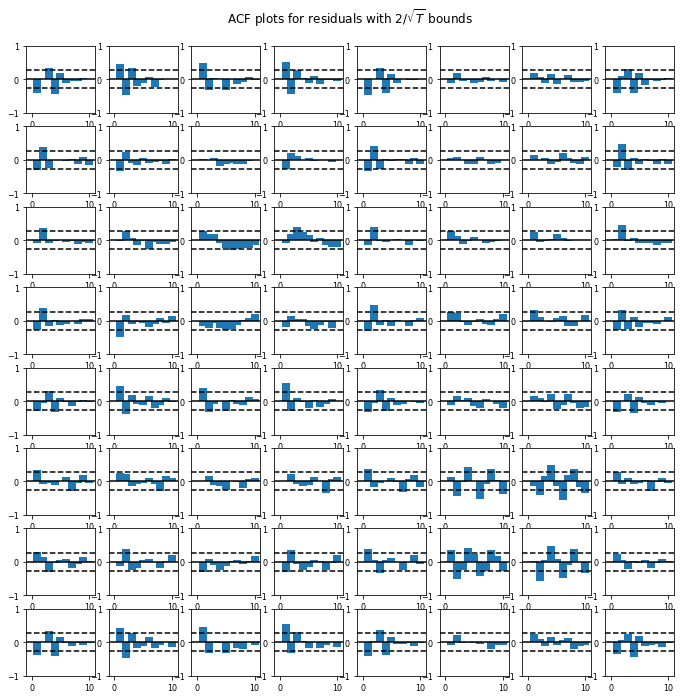

In [50]:
results.plot_acorr()
'model'

In [89]:
model.select_order(15)
results = model.fit(49, ic='aic')
lag_order = results.k_ar
results.plot_forecast(10)
results.forecast(data.values[-lag_order:], 5)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
values = {}
for name in names:
    d = fred.get_series(name, observation_start="2/1/2021", observation_end = "2/1/2021")
    values[name] = d

ValueError: Bad Request.  Invalid value for variable series_id.  Series IDs should be 25 or less alphanumeric characters.

In [ ]:
values["sales"] = 6236
test = pd.DataFrame(values)


In [ ]:
test_data = torch.from_numpy(test.to_numpy())
test_data2 = torch.from_numpy(full[:-3:-1].to_numpy())
test_data = torch.cat([test_data2, test_data]).unsqueeze(0).float()

In [ ]:
model = Model()
model.load_state_dict(torch.load("model.pt"))
model(test_data)

In [ ]:
xg_reg.predict(test)

In [81]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
     

        self.output_block = nn.Sequential(nn.Conv1d(3, 16, 2, 1, 0), nn.ReLU(), 
                                          nn.Conv1d(16, 32, 2, 1, 0), nn.ReLU(), 
                                          nn.Conv1d(32, 32, 2, 1, 0), nn.ReLU(), 
                                          nn.Conv1d(32, 16, 2, 1, 0), nn.ReLU())
        self.fc = nn.Sequential(nn.LazyLinear(512), nn.ReLU(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 1))

    def forward(self, x):
        net = self.output_block(x)
        net = net.view(net.shape[0], -1)
        net = self.fc(net)
        
        return net


In [82]:
target[3:]

,sales
3,1362
4,1225
5,1312
6,1373
7,1530
...,...
60,4797
61,5438
62,6056
63,5773


In [83]:
class dataset(Dataset):
    def __init__(self, df, target):
        data = df[1:].reset_index(drop=True)
        sales = target[:-1].reset_index(drop=True)
        self.data = data.join(sales)
        self.target = target[3:].to_numpy()

    def __len__(self):
        return len(self.data)-3
    def __getitem__(self, idx):
        data = self.data.iloc[idx:idx+3].to_numpy()
        target = self.target[idx]
        return torch.tensor(data).float(), torch.tensor(target).float()
        
    

In [84]:
idx = int(len(data) * 0.8)
train, test = data.iloc(axis=1)[np.where(clf.coef_ != 0)[0]][:idx], data.iloc(axis=1)[np.where(clf.coef_ != 0)[0]][idx:]
traint, testt = target[:idx], target[idx:]
trainset = dataset(train, traint)
testset = dataset(test, testt)
train_loader = DataLoader(trainset, batch_size=8, shuffle=True)
test_loader = DataLoader(testset, batch_size=4, shuffle=True)

In [85]:
model = Model()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25, factor=0.5, min_lr=0.000001)
def Train(epochs, model, train_loader):
    valid_loss_min = np.Inf
    min_rmse = np.Inf
    for epoch in range(epochs):
        train_loss = 0.0
        correct = 0.0
        total = 0.0
        valid_loss = 0.0
        rmse = 0.0
        model.train()
        for batch_idx, (images, labels) in enumerate(train_loader):
       
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
        
            loss = torch.sqrt(criterion(output,labels))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        model.eval()
        for batch_idx, (images, labels) in enumerate(test_loader):
       
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
        
            loss = torch.sqrt(criterion(output,labels))
          
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
                
        scheduler.step(valid_loss)
        print(f"Train Loss: {train_loss.item()}")
        print(f"Valid Loss: {valid_loss.item()}")
        if valid_loss.item() < valid_loss_min:
            valid_loss_min = valid_loss.item()
            torch.save(model.state_dict(), 'model.pt')
    print(f"Min RMSE: {valid_loss_min}")

/home/dwight/miniconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [86]:
Train(1000, model, train_loader)




Train Loss: 36804692.0
Valid Loss: 6631559.0
Train Loss: 965717.0
Valid Loss: 1003341.0625
Train Loss: 157169.8125
Valid Loss: 148701.671875
Train Loss: 18546.599609375
Valid Loss: 24466.734375
Train Loss: 4002.153076171875
Valid Loss: 10286.81640625
Train Loss: 6023.8115234375
Valid Loss: 6605.6181640625
Train Loss: 3065.498291015625
Valid Loss: 5965.46826171875
Train Loss: 2647.583740234375
Valid Loss: 5734.28955078125
Train Loss: 2695.34619140625
Valid Loss: 5899.0791015625
Train Loss: 2686.925537109375
Valid Loss: 5821.5146484375
Train Loss: 2675.387939453125
Valid Loss: 6000.1162109375
Train Loss: 2690.362060546875
Valid Loss: 5821.48486328125
Train Loss: 2679.12353515625
Valid Loss: 5795.2333984375
Train Loss: 2693.272216796875
Valid Loss: 5820.26513671875
Train Loss: 2694.411376953125
Valid Loss: 6024.09033203125
Train Loss: 2677.86962890625
Valid Loss: 5872.21826171875
Train Loss: 2670.9658203125
Valid Loss: 5999.6689453125
Train Loss: 2689.29345703125
Valid Loss: 6054.47216796

Train Loss: 2480.059814453125
Valid Loss: 5523.23095703125
Train Loss: 2496.259033203125
Valid Loss: 5485.56982421875
Train Loss: 2473.904541015625
Valid Loss: 5843.16650390625
Train Loss: 2466.988037109375
Valid Loss: 6277.78857421875
Train Loss: 2490.1025390625
Valid Loss: 6252.39453125
Train Loss: 2504.0322265625
Valid Loss: 5792.03076171875
Train Loss: 2497.982177734375
Valid Loss: 5786.73681640625
Train Loss: 2514.331298828125
Valid Loss: 5534.01318359375
Train Loss: 2462.358154296875
Valid Loss: 5472.755859375
Train Loss: 2500.284912109375
Valid Loss: 5677.1005859375
Train Loss: 2484.76171875
Valid Loss: 5493.61279296875
Train Loss: 2473.030517578125
Valid Loss: 6263.65576171875
Train Loss: 2423.92578125
Valid Loss: 6231.8115234375
Train Loss: 2479.251953125
Valid Loss: 5672.9091796875
Train Loss: 2487.31689453125
Valid Loss: 5778.185546875
Train Loss: 2425.7900390625
Valid Loss: 5522.0068359375
Train Loss: 2441.239501953125
Valid Loss: 5496.00732421875
Train Loss: 2475.850585937

Train Loss: 2452.303955078125
Valid Loss: 6317.384765625
Train Loss: 2405.243896484375
Valid Loss: 5463.8271484375
Train Loss: 2446.973388671875
Valid Loss: 5750.4306640625
Train Loss: 2416.931396484375
Valid Loss: 5460.466796875
Train Loss: 2438.375244140625
Valid Loss: 5463.7314453125
Train Loss: 2454.86181640625
Valid Loss: 5552.01171875
Train Loss: 2450.28466796875
Valid Loss: 5524.06591796875
Train Loss: 2417.056396484375
Valid Loss: 5736.02001953125
Train Loss: 2457.0078125
Valid Loss: 6211.7294921875
Train Loss: 2469.66845703125
Valid Loss: 6324.119140625
Train Loss: 2406.69921875
Valid Loss: 6319.1767578125
Train Loss: 2442.062744140625
Valid Loss: 5450.44140625
Train Loss: 2462.68115234375
Valid Loss: 5606.015625
Train Loss: 2458.708984375
Valid Loss: 5602.2041015625
Train Loss: 2431.106689453125
Valid Loss: 5463.1005859375
Train Loss: 2474.4501953125
Valid Loss: 5462.1015625
Train Loss: 2437.855224609375
Valid Loss: 5456.173828125
Train Loss: 2453.213623046875
Valid Loss: 574

Train Loss: 2476.608642578125
Valid Loss: 5458.23291015625
Train Loss: 2452.859375
Valid Loss: 6331.06103515625
Train Loss: 2466.884765625
Valid Loss: 5545.83935546875
Train Loss: 2437.33740234375
Valid Loss: 5550.11279296875
Train Loss: 2468.36669921875
Valid Loss: 5548.6376953125
Train Loss: 2433.28173828125
Valid Loss: 6323.55224609375
Train Loss: 2462.040771484375
Valid Loss: 5441.7158203125
Train Loss: 2470.5263671875
Valid Loss: 5421.51708984375
Train Loss: 2471.240966796875
Valid Loss: 6316.80322265625
Train Loss: 2441.282958984375
Valid Loss: 6331.98681640625
Train Loss: 2465.858154296875
Valid Loss: 5508.693359375
Train Loss: 2432.349609375
Valid Loss: 5455.9814453125
Train Loss: 2443.96533203125
Valid Loss: 5458.23388671875
Train Loss: 2458.98193359375
Valid Loss: 5548.4658203125
Train Loss: 2421.21923828125
Valid Loss: 5481.693359375
Train Loss: 2456.505126953125
Valid Loss: 5734.0947265625
Train Loss: 2422.50390625
Valid Loss: 6335.36083984375
Train Loss: 2434.0458984375
Va

Train Loss: 2456.514404296875
Valid Loss: 5445.681640625
Train Loss: 2452.88525390625
Valid Loss: 5430.53759765625
Train Loss: 2452.48681640625
Valid Loss: 5546.9931640625
Train Loss: 2423.75927734375
Valid Loss: 6324.68359375
Train Loss: 2459.2177734375
Valid Loss: 5602.48876953125
Train Loss: 2401.29638671875
Valid Loss: 5455.54296875
Train Loss: 2425.245361328125
Valid Loss: 5479.880859375
Train Loss: 2447.2294921875
Valid Loss: 5445.55419921875
Train Loss: 2451.671875
Valid Loss: 5441.29296875
Train Loss: 2454.382080078125
Valid Loss: 5546.64453125
Train Loss: 2413.187255859375
Valid Loss: 6325.64599609375
Train Loss: 2449.38720703125
Valid Loss: 5476.7685546875
Train Loss: 2451.895751953125
Valid Loss: 6322.86962890625
Train Loss: 2444.5126953125
Valid Loss: 5393.7939453125
Train Loss: 2431.49658203125
Valid Loss: 6210.845703125
Train Loss: 2471.464111328125
Valid Loss: 5546.99169921875
Train Loss: 2397.10498046875
Valid Loss: 5694.74560546875
Train Loss: 2441.51220703125
Valid Lo

Train Loss: 2446.332275390625
Valid Loss: 5619.7822265625
Train Loss: 2424.626708984375
Valid Loss: 6217.9033203125
Train Loss: 2446.319580078125
Valid Loss: 5435.21142578125
Train Loss: 2469.562744140625
Valid Loss: 6203.95361328125
Train Loss: 2440.5537109375
Valid Loss: 5404.87890625
Train Loss: 2472.308349609375
Valid Loss: 5416.5947265625
Train Loss: 2418.437744140625
Valid Loss: 6314.9013671875
Train Loss: 2434.564453125
Valid Loss: 5775.47314453125
Train Loss: 2464.493896484375
Valid Loss: 5727.57958984375
Train Loss: 2443.24560546875
Valid Loss: 5448.56396484375
Train Loss: 2450.6513671875
Valid Loss: 5775.41650390625
Train Loss: 2440.916748046875
Valid Loss: 5660.27392578125
Train Loss: 2455.8232421875
Valid Loss: 6315.93603515625
Train Loss: 2420.470703125
Valid Loss: 5544.4814453125
Train Loss: 2444.420166015625
Valid Loss: 5547.5048828125
Train Loss: 2447.0595703125
Valid Loss: 6307.33740234375
Train Loss: 2426.910400390625
Valid Loss: 5434.87353515625
Train Loss: 2438.6735

Train Loss: 2418.501708984375
Valid Loss: 5386.5546875
Train Loss: 2441.634765625
Valid Loss: 5539.83984375
Train Loss: 2435.770751953125
Valid Loss: 5448.17333984375
Train Loss: 2426.34228515625
Valid Loss: 5448.27294921875
Train Loss: 2457.53466796875
Valid Loss: 5415.00634765625
Train Loss: 2412.841064453125
Valid Loss: 5616.39453125
Train Loss: 2441.207275390625
Valid Loss: 6322.10791015625
Train Loss: 2428.130126953125
Valid Loss: 5469.46484375
Train Loss: 2417.96630859375
Valid Loss: 5724.3203125
Train Loss: 2436.327392578125
Valid Loss: 5448.26513671875
Train Loss: 2452.361328125
Valid Loss: 5697.15234375
Train Loss: 2440.962158203125
Valid Loss: 5449.23876953125
Train Loss: 2410.1123046875
Valid Loss: 5687.2275390625
Train Loss: 2446.984619140625
Valid Loss: 5697.2392578125
Train Loss: 2406.78173828125
Valid Loss: 5447.2216796875
Train Loss: 2453.379150390625
Valid Loss: 5539.82177734375
Train Loss: 2364.12353515625
Valid Loss: 5723.81640625
Train Loss: 2419.265380859375
Valid 